In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics

import dask
import timeit

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
from dask.distributed import Client
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:46141 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 67.47 GB


In [3]:
metrics_all = ['anomaly','mean','SIP']
runType = 'forecast'
variables = ['sic']

In [4]:
# Time period options
Last_valid_time = np.datetime64('2018-11-30') # last day in valid time space to include in anlaysis

In [5]:
# Get path data
E = ed.EsioData.load()
grid_dir = E.grid_dir

# Load in regional data
ds_region = xr.open_dataset(os.path.join(grid_dir, 'sio_2016_mask_Update.nc'))

In [6]:
cvar = variables[0]

In [7]:
# Define fig dir and make if doesn't exist
fig_dir = os.path.join('/home/disk/sipn/nicway/Nic/figures', 'model', 'MME', cvar, 'BSS')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [8]:
# Load from Zarr
ds_m = xr.open_zarr('/home/disk/sipn/nicway/data/model/zarr/sic.zarr')

In [9]:
ds_m = import_data.get_valid_time(ds_m, init_dim='init_end')

In [10]:
# Select only initlizations from January 2018 to November 2018 (for GRL paper)
ds_m = ds_m.where(ds_m.valid_time<=Last_valid_time, drop=True)

In [11]:
# Drop models we don't want
ds_m = ds_m.where(ds_m.model!='dampedAnomaly', drop=True)

In [12]:
def remove_list(X, L):
    for cl in L:
        X.remove(cl)

In [13]:
ds_ALL = ds_m # rename for new Zarr format usage

In [14]:
# # Drop models that we don't evaluate (i.e. monthly means)
exl_mods = ['awispin','nicosipn','szapirosipn']

In [15]:
# Order models to plot in
models_first = ['climatology','dampedAnomalyTrend','MME']
X = list(ds_ALL.model.values)
[X.remove(a) for a in models_first]
model_plot_order = models_first + X
model_plot_order.remove('Observed')
model_plot_order

['climatology',
 'dampedAnomalyTrend',
 'MME',
 'awispin',
 'ecmwf',
 'ecmwfsipn',
 'gfdlsipn',
 'kma',
 'metreofr',
 'ncep',
 'nicosipn',
 'rasmesrl',
 'szapirosipn',
 'ukmetofficesipn',
 'ukmo',
 'usnavygofs',
 'usnavyncep',
 'usnavysipn',
 'yopp']

In [16]:
# def IIEE(da_mod=None, da_obs=None, region=None, sic_threshold=0.15, testplots=False):
#     ''' The Integrated Ice‐Edge Error Goessling 2016'''
    
#     # Input
#     # da_mod/da_obs - DataArray of sic from model/observations
    
#     # Output
#     # IEEE - Area of IEEE in millions of km^2, 
    
#     # Should already be formated the same
#     assert (sorted(da_mod.dims) == sorted(da_obs.dims)), "Dims should be the same."
    
#     # spatial dims in model and obs should be 'x' and 'y' to match regions var names
#     assert ('x' in da_mod.dims), "'x' and 'y' should be dims."
#     assert ('y' in da_obs.dims), "'x' and 'y' should be dims"
    
#     # Reduce to sea ice presence
#     mod_sip = (da_mod >= sic_threshold).where(da_mod.notnull())
#     obs_sip = (da_obs >= sic_threshold).where(da_obs.notnull())
    
#     # Mask to regions of Arctic we are interested in
#     mod_sip = mod_sip.where(region.mask.isin(region.ocean_regions))
#     obs_sip = obs_sip.where(region.mask.isin(region.ocean_regions))
    
#     if testplots:
#         plt.figure()
#         (abs(mod_sip - obs_sip)).plot()
    
#     # Calculate both terms (over and under area) in km^2
#     IIEE = (abs(mod_sip - obs_sip) * region.area ).sum(dim=['x','y'])/(10**6)
    
#     # Remove IIEE values of zero where model was all NaN's
#     have_forecast = mod_sip.sum(['x','y']) > 0
#     IIEE = IIEE.where(have_forecast)
    
#     return IIEE



# temp_IIEE = IIEE(da_mod=ds_ALL.sel(model='ukmetofficesipn')['mean'], 
#                  da_obs=ds_ALL.sel(model='Observed')['mean'], 
#                  region=ds_region, sic_threshold=0.15, testplots=False)

In [17]:
# Calculate the IIEE (Integrated Ice Edge Error)
l = []
for cmod in ds_ALL.model.values: 
    c_SIP_IIEE = metrics.IIEE(da_mod=ds_ALL.sel(model=cmod)['mean'], 
                                      da_obs=ds_ALL.sel(model='Observed')['mean'], 
                                      region=ds_region, 
                                      testplots=False)
    c_SIP_IIEE.coords['model'] = cmod
    l.append(c_SIP_IIEE)
SIP_IIEE = xr.concat(l, dim='model')
SIP_IIEE

<xarray.DataArray (model: 20, init_end: 47, fore_time: 14)>
dask.array<shape=(20, 47, 14), dtype=float64, chunksize=(1, 1, 1)>
Coordinates:
  * fore_time   (fore_time) timedelta64[ns] 0 days 7 days ... 274 days 304 days
  * init_end    (init_end) datetime64[ns] 2018-01-07 2018-01-14 ... 2018-11-25
    valid_time  (init_end, fore_time) datetime64[ns] 2018-01-07 ... 2019-09-25
  * model       (model) <U18 'Observed' 'awispin' 'climatology' ... 'yopp' 'MME'

In [18]:
# For SIP, calculate the Brier Skill Score for panArctic 
# BS = (SIP_model - SIP_observed)^2
#
l = []
for cmod in ds_ALL.model.values: 
    c_SIP_BSS = metrics.BrierSkillScore(da_mod_sip=ds_ALL.sel(model=cmod).SIP, 
                                      da_obs_ip=ds_ALL.sel(model='Observed').SIP, 
                                      region=ds_region, 
                                      testplots=False)
    c_SIP_BSS.coords['model'] = cmod
    l.append(c_SIP_BSS)
SIP_BSS = xr.concat(l, dim='model')

In [19]:
SIP_BSS.model

<xarray.DataArray 'model' (model: 20)>
array(['Observed', 'awispin', 'climatology', 'dampedAnomalyTrend', 'ecmwf',
       'ecmwfsipn', 'gfdlsipn', 'kma', 'metreofr', 'ncep', 'nicosipn',
       'rasmesrl', 'szapirosipn', 'ukmetofficesipn', 'ukmo', 'usnavygofs',
       'usnavyncep', 'usnavysipn', 'yopp', 'MME'], dtype='<U18')
Coordinates:
  * model    (model) <U18 'Observed' 'awispin' 'climatology' ... 'yopp' 'MME'

In [20]:
# Load into memory here (do compute once instead of many times below)
# SIP_BSS.persist()

In [21]:
def add_subplot_title(cmod, E, ax=None, BSS_val=''):
    if cmod in E.model.keys():
        ax.set_title((E.model[cmod]['model_label']).rstrip('*')+'\n('+BSS_val+')')
    else:
        ax.set_title(cmod)

In [22]:
# add missing info for climatology
E.model_color['climatology'] = (0,0,0)
E.model_linestyle['climatology'] = '--'
E.model_marker['climatology'] = '*'
E.model['climatology'] = {'model_label':'Climatology\nTrend'}

In [23]:
# Aggregate over space (x,y), including all pixels in valid Arctic seas (masked above with BrierSkillScore())
BSS_agg = SIP_BSS.mean(dim=['x','y'])
BSS_agg.load()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:46816 remote=tcp://127.0.0.1:46141>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:46818 remote=tcp://127.0.0.1:46141>


<xarray.DataArray (model: 20, init_end: 47, fore_time: 14)>
array([[[0.      , 0.      , ..., 0.      ,      nan],
        [0.      , 0.      , ..., 0.      ,      nan],
        ...,
        [0.      , 0.      , ...,      nan,      nan],
        [0.      ,      nan, ...,      nan,      nan]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       ...,

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [0.023934, 0.118092, ...,      nan,      nan],
        [0.123747,      nan, ...,      nan,      nan]],

       [[0.026176, 0.028693, ...,      nan,      nan],
        [0.028825, 0.031802, ...,      nan,      nan],
        ...,
        [0.023972, 0.11826 , ...,      nan,      nan],
        [0.123827,      nan, ...,      nan, 

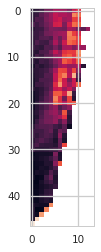

In [24]:
plt.imshow(BSS_agg.sel(model='MME').values)

### At what lead time is the MME significantly (95%) better than the Damped Anomaly?

In [25]:
from scipy import stats

model_1 = 'MME'
model_2 = 'dampedAnomalyTrend'
alphaval = 0.05 # 95%

In [26]:
t_all=[]
p_all=[]
cv_all=[]
for ft in np.arange(0,BSS_agg.fore_time.size):
    x = BSS_agg.sel(model=model_1).isel(fore_time=ft)
    y = BSS_agg.sel(model=model_2).isel(fore_time=ft)
    
    x = x.where(x.notnull() & y.notnull(), drop=True)
    y = y.where(x.notnull() & y.notnull(), drop=True)
    
    df = x.size + y.size -2
    
#     plt.figure()
#     x.plot.hist(alpha=0.5, label=model_1)
#     y.plot.hist(alpha=0.5, label=model_2)
#     plt.legend()
    
    t, p = stats.ttest_ind(x, y, equal_var=False)
    cv = stats.t.ppf(1.0 - alphaval, df)
    
    t_all.append(t)
    p_all.append(p)
    cv_all.append(cv)


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


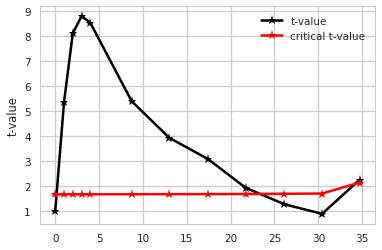

In [27]:
plt.figure()
plt.plot(BSS_agg.fore_time.values.astype('timedelta64[D]').astype(int)/7,
        abs(np.array(t_all)),'-k*', label='t-value')
plt.plot(BSS_agg.fore_time.values.astype('timedelta64[D]').astype(int)/7,
        cv_all,'-r*', label='critical t-value')
plt.ylabel('t-value')
plt.legend()

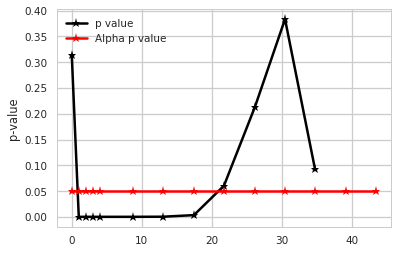

In [28]:
plt.figure()
plt.plot(BSS_agg.fore_time.values.astype('timedelta64[D]').astype(int)/7,
        p_all,'-k*',label='p value')
plt.plot(BSS_agg.fore_time.values.astype('timedelta64[D]').astype(int)/7,
        np.ones(len(p_all))*alphaval,'-r*',label='Alpha p value')
plt.ylabel('p-value')
plt.legend()

### Plot BS spatial plots for 1 month lead time

['climatology', 'dampedAnomalyTrend', 'MME', 'ecmwf', 'ecmwfsipn', 'gfdlsipn', 'kma', 'metreofr', 'ncep', 'rasmesrl', 'ukmetofficesipn', 'ukmo', 'usnavygofs', 'usnavyncep', 'usnavysipn', 'yopp']
28


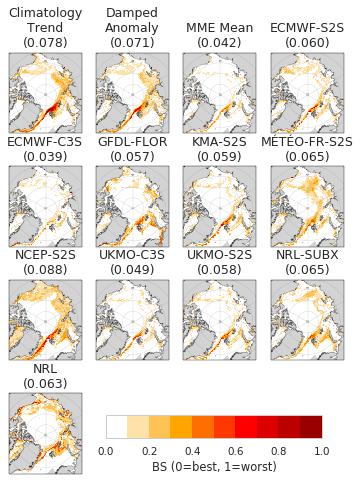

In [29]:
# Remove some select models
enough_init = model_plot_order.copy()
[enough_init.remove(a) for a in exl_mods]
print(enough_init)

SIP_BSS_init_avg = SIP_BSS.sel(model=enough_init).mean(dim='init_end')

sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

# Set up color maps
cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
cmap_c.set_bad(color = 'lightgrey')
c_label = 'BS (0=best, 1=worst)'
c_vmin = 0
c_vmax = 1

for ft in [SIP_BSS_init_avg.fore_time.values[4]]:  
    
    # Grab current lead time
    c_ft_ds = SIP_BSS_init_avg.sel(fore_time=ft)
    
    # Drop models without any data
    c_ft_ds = c_ft_ds.where(c_ft_ds.notnull().sum(dim=['x','y'])>0, drop=True)
    
    nrows = np.int(np.ceil(np.sqrt(c_ft_ds.model.size)))
    ncols = int(np.ceil(c_ft_ds.model.size/nrows))
    Nplots = c_ft_ds.model.size + 1
    
    # New Plot
    central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
    (f, axes) = ice_plot.multi_polar_axis(ncols=ncols, nrows=nrows, Nplots=Nplots, 
                                          extent=central_extent, central_longitude=0)

    for (i, cmod) in enumerate(c_ft_ds.model.values):
        if cmod in c_ft_ds.model.values:
            # Plot
            add_subplot_title(cmod, E, ax=axes[i])
            p = c_ft_ds.sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False,
                                  cmap=cmap_c,
                                  vmin=c_vmin, vmax=c_vmax)
            add_subplot_title(cmod, E, ax=axes[i], BSS_val='{0:.3f}'.format(c_ft_ds.sel(model=cmod).mean(dim=['x','y']).load().item()))

    # Make pretty
    #f.subplots_adjust(bottom=0.05)
    # cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    #cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
    cbar_ax = f.add_axes([0.35, 0.2, .5, 0.04]) #  [left, bottom, width, height] w
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
    cbar.set_ticks(np.arange(-1,1.1,0.2))
    
    # Set title of all plots
    lead_time_days = str(ft.astype('timedelta64[D]').astype(int))
    print(lead_time_days)
#     plt.suptitle(lead_time_days+' day lead time', fontsize=15)
#     plt.subplots_adjust(top=0.93)

    # Save to file
    f_out = os.path.join(fig_dir,'BSS_Avg_all_Inits_'+lead_time_days.zfill(3)+'_day_lead_time.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)

### Plot Brier Score vs lead time


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


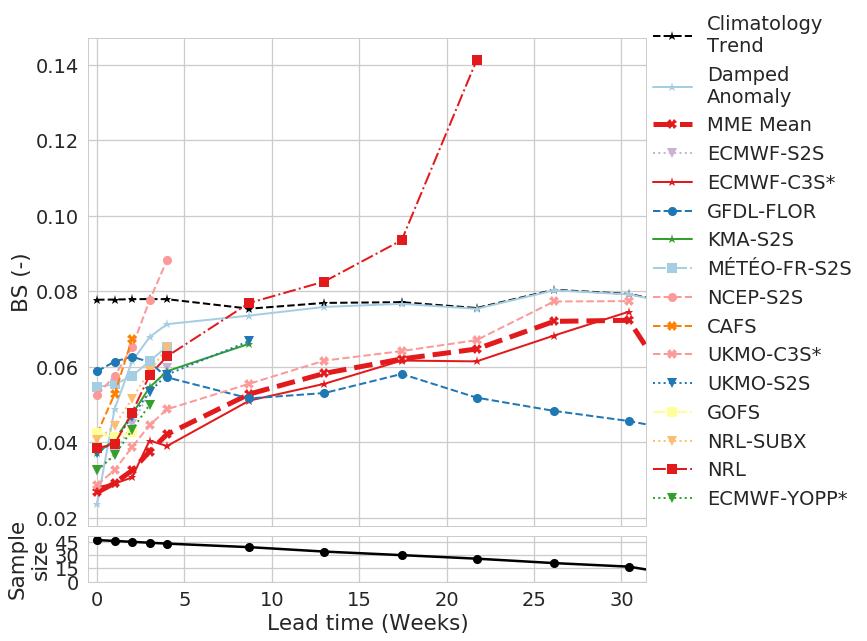

In [30]:
min_N_samples = 10 # Min number of samples to allow for mean
BSS_agg_init = BSS_agg.mean(dim='init_end')

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Get sample size of for each lead time
for_sample = BSS_agg.sel(model='MME').notnull().sum(dim='init_end')
for_sample

# Use threshold of sample size to cut off lead times
max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

f = plt.figure(figsize=(10,10))
NM = 10
ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)
ax2 = plt.subplot2grid((NM, NM), (NM-1, 0), colspan=NM, rowspan=1)

for cmod in model_plot_order:
    if cmod in exl_mods:
        continue
    # Get model plotting specs
    cc = E.model_color[cmod]
    cl = E.model_linestyle[cmod]
    cm = E.model_marker[cmod]
    if cmod=='MME':
        lw=5
        
    else:
        lw = 2
    ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            BSS_agg_init.sel(model=cmod).values, label=E.model[cmod]['model_label'],
            color=cc,
            linestyle=cl,
            linewidth=lw,
            marker=cm)
ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
ax1.set_ylabel('BS (-)')
ax1.set_xlim([-0.5,max_lead+1])
ax1.set_xticklabels([''])

# second axis
ax2.plot(for_sample.fore_time.values.astype('timedelta64[D]').astype(int)/7,
         for_sample.values, '-ko')
ax2.set_ylabel('Sample\nsize')
ax2.set_xlabel('Lead time (Weeks)')
ax2.set_xlim(ax1.get_xlim());

ax2.set_ylim([0,for_sample.max()+5]);
ax2.set_yticks(np.arange(0,for_sample.max()+5,15));

# Save to file
f_out = os.path.join(fig_dir,'BSS_by_lead_time_PanArctic.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)

### Plot the IIEE with lead time

In [31]:
SIP_IIEE.load()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:46946 remote=tcp://127.0.0.1:46141>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:46948 remote=tcp://127.0.0.1:46141>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:46950 remote=tcp://127.0.0.1:46141>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:46952 remote=tcp://127.0.0.1:46141>
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


<xarray.DataArray (model: 20, init_end: 47, fore_time: 14)>
array([[[0.      , 0.      , ..., 0.      ,      nan],
        [0.      , 0.      , ..., 0.      ,      nan],
        ...,
        [0.      , 0.      , ...,      nan,      nan],
        [0.      ,      nan, ...,      nan,      nan]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       ...,

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [0.410421, 0.559993, ...,      nan,      nan],
        [0.556984,      nan, ...,      nan,      nan]],

       [[0.592173, 0.687922, ...,      nan,      nan],
        [0.621447, 0.707984, ...,      nan,      nan],
        ...,
        [0.471816, 0.548014, ...,      nan,      nan],
        [0.566399,      nan, ...,      nan, 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


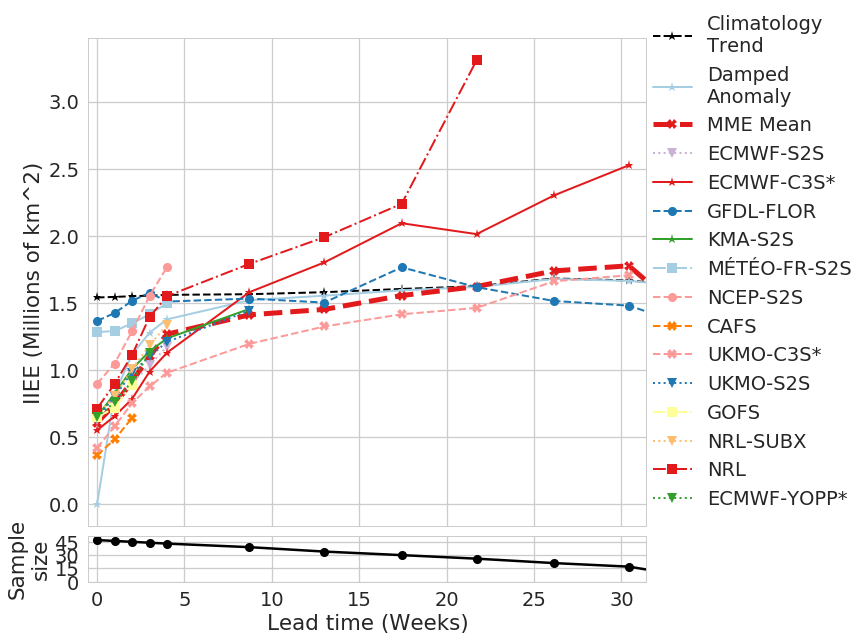

In [32]:
min_N_samples = 10 # Min number of samples to allow for mean
SIP_IIEE_init = SIP_IIEE.mean(dim='init_end')

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Get sample size of for each lead time
for_sample = SIP_IIEE.sel(model='MME').notnull().sum(dim='init_end')

# Use threshold of sample size to cut off lead times
max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

f = plt.figure(figsize=(10,10))
NM = 10
ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)
ax2 = plt.subplot2grid((NM, NM), (NM-1, 0), colspan=NM, rowspan=1)

for cmod in model_plot_order:
    if cmod in exl_mods:
        continue
    # Get model plotting specs
    cc = E.model_color[cmod]
    cl = E.model_linestyle[cmod]
    cm = E.model_marker[cmod]
    if cmod=='MME':
        lw=5
        
    else:
        lw = 2
    ax1.plot(SIP_IIEE_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            SIP_IIEE_init.sel(model=cmod).values, label=E.model[cmod]['model_label'],
            color=cc,
            linestyle=cl,
            linewidth=lw,
            marker=cm)
ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
ax1.set_ylabel('IIEE (Millions of km^2)')
ax1.set_xlim([-0.5,max_lead+1])
ax1.set_xticklabels([''])

# second axis
ax2.plot(for_sample.fore_time.values.astype('timedelta64[D]').astype(int)/7,
         for_sample.values, '-ko')
ax2.set_ylabel('Sample\nsize')
ax2.set_xlabel('Lead time (Weeks)')
ax2.set_xlim(ax1.get_xlim());

ax2.set_ylim([0,for_sample.max()+5]);
ax2.set_yticks(np.arange(0,for_sample.max()+5,15));

# Save to file
f_out = os.path.join(fig_dir,'IIEE_by_lead_time_PanArctic.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)

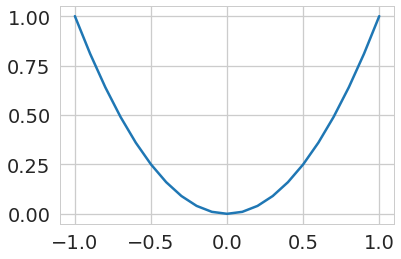

In [33]:
d = np.arange(-1,1.1,0.1)
bs = d**2
plt.plot(d,bs)

In [34]:
# MaxLeadTime_With_Data = BSS_agg_init.where(BSS_agg_init.notnull(), drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)

In [35]:
## Plot week 0 BSS vs. ice/ocean assimilation sources

In [36]:
# We divide up models based on their initilaization / DA methods/variables
#
# What observations are used?
# SIC, SIT, SST, OPO (Ocean profile observations)
#
# What method is used?
# DI (Direct insertion), NG (Nudging), OI (Optimal interpolation), 4DVAR (4D Variance), 3DVAR (3D Variance), EnKF (Ensemble Kalmen Filter)

In [37]:
# # copy past info from Table 1
# DA_dict = {
# 'modcansipns_3':'SIC (NG)', 
# 'modcansipns_4':'SIC (NG)',
# 'ecmwfsipn':'SIC (4DVAR), SST (4DVAR), OPO (4DVAR)', 
# 'ecmwf':'SIC (4DVAR), SST (4DVAR), OPO (4DVAR)',
# 'yopp':'SIC (4DVAR), SST (4DVAR), OPO (4DVAR)',
# 'gfdlsipn':'SST (EnKF), OPO (EnKF)',
# 'metreofr':'SIC (EnKF), SST (EnKF), OPO (EnKF)',
# 'szapirosipn':'No-DA',
# 'ncep-exp-bias-corr':'SIC (NG), SST (3DVAR), OBO (3DVAR)',
# 'noaasipn':'SIC (NG), SST (3DVAR), OBO (3DVAR)',
# 'usnavysipn':'SIC (3DVAR), SST (3DVAR), OPO (3DVAR)',
# 'usnavyncep':'SIC (3DVAR), SST (3DVAR), OPO (3DVAR)',
# 'usnavygofs':'SIC (3DVAR), SST (3DVAR), OPO (3DVAR)',
# 'rasmesrl':'SIC (DI), SIT* (DI), SST (?)',
# 'uclsipn':'No-DA',
# 'ukmetofficesipn':'SIC (3DVAR), SST (3DVAR), OPO (3DVAR)',
# 'ukmo':'SIC (3DVAR), SST (3DVAR), OPO (3DVAR)',
# 'ncep':'SIC (NG), SST (3DVAR), OBO (3DVAR)',
# 'kma':'SIC (3DVAR), SST (3DVAR), OPO (3DVAR)'
# }

# # Add models
# DA_dict['climatology'] = 'No-DA'
# DA_dict['dampedAnomalyTrend'] = 'SIC (DI)'
# DA_dict['MME'] = 'Variable'
# DA_dict

In [38]:
# Simple version

In [39]:
# copy past info from Table 1
DA_dict = {
'modcansipns_3':'SIC (NG)', 
'modcansipns_4':'SIC (NG)',
'ecmwfsipn':'SIC (4DVAR)', 
'ecmwf':'SIC (4DVAR)',
'yopp':'SIC (4DVAR)',
'gfdlsipn':'No Sea Ice DA',
'metreofr':'SIC (EnKF)',
'szapirosipn':'No Sea Ice DA',
'ncep-exp-bias-corr':'SIC (NG)',
'noaasipn':'SIC (NG)',
'usnavysipn':'SIC (3DVAR)',
'usnavyncep':'SIC (3DVAR)',
'usnavygofs':'SIC (3DVAR)',
'rasmesrl':'SIC (DI), SIT* (DI)',
'uclsipn':'No Sea Ice DA',
'ukmetofficesipn':'SIC (3DVAR)',
'ukmo':'SIC (3DVAR)',
'ncep':'SIC (NG)',
'kma':'SIC (3DVAR)'
}

# Add models
DA_dict['climatology'] = 'No Sea Ice DA'
DA_dict['dampedAnomalyTrend'] = 'SIC (DI)'
DA_dict['MME'] = 'MME'
DA_dict

{'MME': 'MME',
 'climatology': 'No Sea Ice DA',
 'dampedAnomalyTrend': 'SIC (DI)',
 'ecmwf': 'SIC (4DVAR)',
 'ecmwfsipn': 'SIC (4DVAR)',
 'gfdlsipn': 'No Sea Ice DA',
 'kma': 'SIC (3DVAR)',
 'metreofr': 'SIC (EnKF)',
 'modcansipns_3': 'SIC (NG)',
 'modcansipns_4': 'SIC (NG)',
 'ncep': 'SIC (NG)',
 'ncep-exp-bias-corr': 'SIC (NG)',
 'noaasipn': 'SIC (NG)',
 'rasmesrl': 'SIC (DI), SIT* (DI)',
 'szapirosipn': 'No Sea Ice DA',
 'uclsipn': 'No Sea Ice DA',
 'ukmetofficesipn': 'SIC (3DVAR)',
 'ukmo': 'SIC (3DVAR)',
 'usnavygofs': 'SIC (3DVAR)',
 'usnavyncep': 'SIC (3DVAR)',
 'usnavysipn': 'SIC (3DVAR)',
 'yopp': 'SIC (4DVAR)'}

In [40]:
DA_options = sorted(list(set(DA_dict.values())))
DA_options

['MME',
 'No Sea Ice DA',
 'SIC (3DVAR)',
 'SIC (4DVAR)',
 'SIC (DI)',
 'SIC (DI), SIT* (DI)',
 'SIC (EnKF)',
 'SIC (NG)']

In [41]:
DA_options = [DA_options[0],DA_options[3],  DA_options[4], DA_options[6], DA_options[1], DA_options[2], DA_options[5], DA_options[7],] # Reorder from simple to complex
DA_options_i = np.arange(len(DA_options))
DA_options_dict = dict(zip(DA_options,DA_options_i))
DA_options_dict

{'MME': 0,
 'No Sea Ice DA': 4,
 'SIC (3DVAR)': 5,
 'SIC (4DVAR)': 1,
 'SIC (DI)': 2,
 'SIC (DI), SIT* (DI)': 6,
 'SIC (EnKF)': 3,
 'SIC (NG)': 7}

Observed not in dict
awispin not in dict
nicosipn not in dict


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


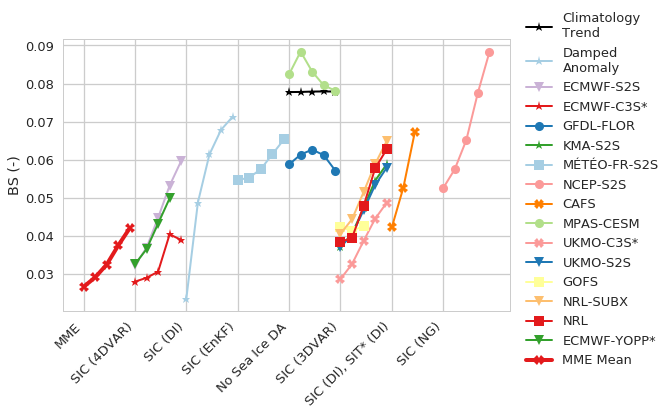

In [42]:
# In place a multi lead times

# Lead times to plot


leads2plot = [0,1,2,3,4] # indices

sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.5})
f, axes = plt.subplots(1, 1, figsize=(8, 5))

for cmod in BSS_agg.model.values:
    if cmod in DA_dict.keys():
        # Get model plotting specs
        cc = E.model_color[cmod]
        cl = E.model_linestyle[cmod]
        cm = E.model_marker[cmod]
        if cmod=='MME':
            lw=4
        else:
            lw=2

        BSS_init = BSS_agg.sel(model=cmod).isel(fore_time=leads2plot).mean(dim='init_end').load()

        #rand_jit = np.random.randint(-100,100)/1000*2
        c_x = np.linspace(DA_options_dict[DA_dict[cmod]],
                          DA_options_dict[DA_dict[cmod]]+0.9,
                          len(leads2plot))
        #print(c_x)
        
        axes.plot(c_x, 
                BSS_init.values,
                color=cc,
                linestyle='-',
                linewidth=lw,
                marker=cm,
                label=E.model[cmod]['model_label'])
    else:
        print(cmod,"not in dict")
axes.set_xticks(DA_options_i)
axes.set_xticklabels(DA_options, rotation='45', ha='right')

plt.legend(loc='lower right', bbox_to_anchor=(1.36, -.25))
plt.ylabel('BS (-)')

# Save to file
f_out = os.path.join(fig_dir,'DA','BSS_week_Multi_by_DA_Type.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)

In [43]:
# sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

# for (ft_i, ft) in enumerate(BSS_agg.fore_time.values):
#     BSS_init = BSS_agg.isel(fore_time=ft_i).mean(dim='init_end').load()

#     f, axes = plt.subplots(1, 1, figsize=(5, 5))

#     for cmod in BSS_init.model.values:
#         if cmod in DA_dict.keys():
#             # Get model plotting specs
#             cc = E.model_color[cmod]
#             cl = E.model_linestyle[cmod]
#             cm = E.model_marker[cmod]
#             if cmod=='MME':
#                 lw=4
#             else:
#                 lw = 2
            
#             rand_jit = np.random.randint(-100,100)/1000*2
#             axes.plot(DA_options_dict[DA_dict[cmod]]+rand_jit, BSS_init.sel(model=cmod).values,
#                         color=cc,
#                         linestyle='None',
#                         linewidth=lw,
#                         marker=cm,
#                         label=E.model[cmod]['model_label'])
#         else:
#             print(cmod,"not in dict")
#     axes.set_xticks(DA_options_i)
#     axes.set_xticklabels(DA_options, rotation='45', ha='right')

#     plt.legend(loc='lower right', bbox_to_anchor=(1.45, 0))
#     plt.ylabel('BSS (-)')

#     # Save to file
#     f_out = os.path.join(fig_dir,'DA','BSS_week_'+str(ft_i)+'_by_DA_Type.png')
#     f.savefig(f_out,bbox_inches='tight', dpi=300)

In [44]:
# BSS_agg_init_short = BSS_agg_init.isel(fore_time=slice(0,5))

# sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
# f = plt.figure(figsize=(10,10))
# for cmod in BSS_agg_init_short.model.values:
#     # Get model plotting specs
#     cc = E.model_color[cmod]
#     cl = E.model_linestyle[cmod]
#     cm = E.model_marker[cmod]
#     if cmod=='MME':
#         lw=5
#     else:
#         lw = 2
#     plt.plot(BSS_agg_init_short.fore_time.values.astype('timedelta64[D]').astype(int)/7 + 1,
#             BSS_agg_init_short.sel(model=cmod).values, label=E.model[cmod]['model_label'],
#             color=cc,
#             linestyle=cl,
#             linewidth=lw,
#             marker=cm)
# plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
# plt.ylabel('BSS (-)')
# plt.xlabel('Lead time (Weeks)')
# plt.xlim([0,30])
# # Save to file
# f_out = os.path.join(fig_dir,'BSS_by_lead_time_short.png')
# f.savefig(f_out,bbox_inches='tight', dpi=300)

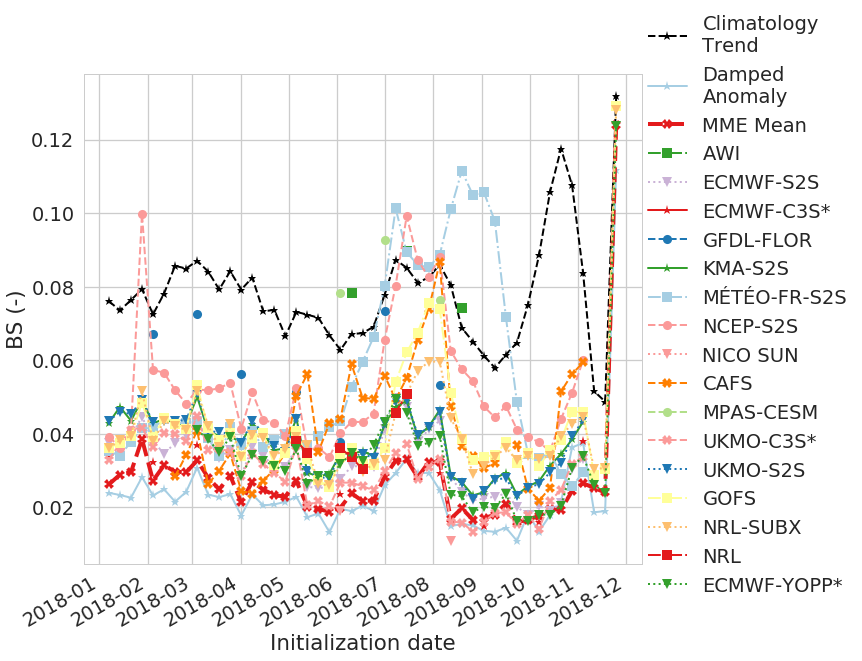

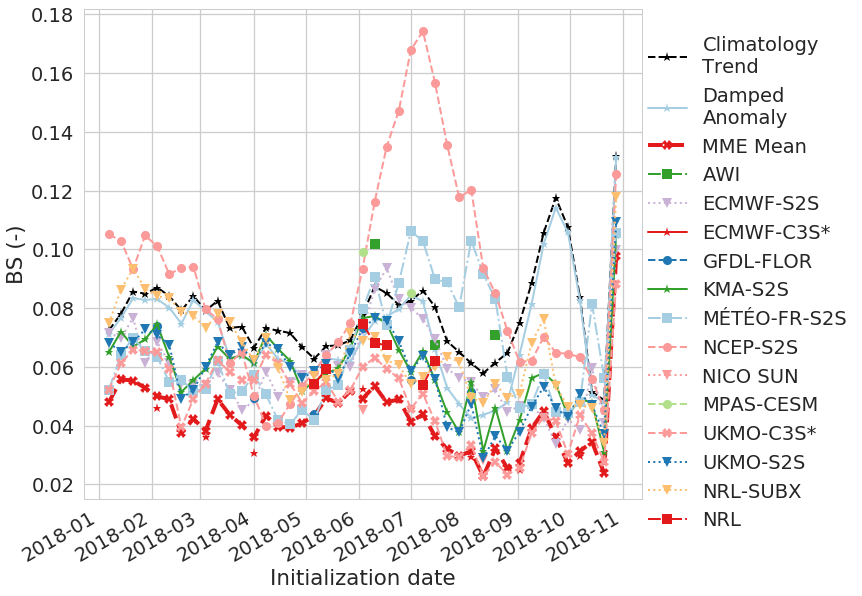

In [45]:
# Plot BSS by init time for 1 selected fore_time
# 4 = 28 days
for ft_i in [0,4]:
    BSS_agg_fore = BSS_agg.isel(fore_time=ft_i)

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
    f = plt.figure(figsize=(10,10))
    for cmod in model_plot_order:
        # Get model plotting specs
        cc = E.model_color[cmod]
        cl = E.model_linestyle[cmod]
        cm = E.model_marker[cmod]
        if cmod=='MME':
            lw=4
        else:
            lw = 2
        if BSS_agg_fore.sel(model=cmod).notnull().sum().values==0:
            continue # Don't plot
        plt.plot(BSS_agg_fore.init_end.values,
                BSS_agg_fore.sel(model=cmod).values, label=E.model[cmod]['model_label'],
                color=cc,
                linestyle=cl,
                linewidth=lw,
                marker=cm)
    plt.legend(loc='lower right', bbox_to_anchor=(1.4, -0.1))
    plt.ylabel('BS (-)')
    plt.xlabel('Initialization date')
    #plt.title(BSS_agg_fore.fore_time.values.astype('timedelta64[D]').astype(int))
    f.autofmt_xdate()
    # Save to file
    f_out = os.path.join(fig_dir,'BSS_by_init_time_'+str(BSS_agg_fore.fore_time.values.astype('timedelta64[D]').astype(int))+'_days.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)

In [46]:
# # Plot init_time vs. fore_time BSS for select models
# ft_i = 6 
# BSS_agg_fore = BSS_agg.isel(fore_time=ft_i)
# BSS_agg_init = BSS_agg.mean(dim='init_end')

# f = plt.figure()
# plt.pcolormesh(BSS_agg_fore.init_end.values, 
#                BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int), 
#                BSS_agg.sel(model='MME').T.values)
# plt.colorbar()
# f.autofmt_xdate()
# plt.ylabel('Lead time (Days)')

In [47]:
# BSS_agg_MAX = BSS_agg.max()

In [48]:
# sns.set_style('ticks')
# sns.set_context("talk", font_scale=1.3, rc={"lines.linewidth": 2.5})
# # Plot init_time vs. fore_time BSS for select models
# BSS_agg_fore = BSS_agg.isel(fore_time=0)
# BSS_agg_init = BSS_agg.mean(dim='init_end')

# Ncols=5
# Nrows=4

# f, (axes) = plt.subplots(ncols=Ncols, nrows=Nrows)    
# f.set_size_inches(20, 15)

# axes = axes.reshape(-1)
# for (i,cmod) in enumerate(BSS_agg.model.values):
#     p = axes[i].pcolormesh(BSS_agg_fore.init_end.values, 
#                BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int), 
#                BSS_agg.sel(model=cmod).T.values,
#                       cmap='Blues', vmin=0, vmax=0.1)
#     axes[i].set_title(E.model[cmod]['model_label'])
#     axes[i].set_ylim([0,MaxLeadTime_With_Data])
#     if np.any(i in np.arange(0,Ncols*Nrows,5)):
#         axes[i].set_ylabel('Lead time (Days)')
#     else:
#         axes[i].set_yticklabels([])

# f.autofmt_xdate()   

# # Add colorbar
# f.subplots_adjust(right=0.8)
# cbar_ax = f.add_axes([0.85, 0.15, 0.025, 0.7])
# cbar = f.colorbar(p, cax=cbar_ax, label='Brier Skill Score (-)')

# f_out = os.path.join(fig_dir,'BSS_init_vs_fore_time.png')
# f.savefig(f_out,bbox_inches='tight', dpi=300)

In [49]:
# # Test skill at various lead times for one valid/target week
# BSS_agg = import_data.get_valid_time(BSS_agg, init_dim='init_end')






# tar_week_start = np.datetime64('2018-07-01')
# tar_week_end = np.datetime64('2018-07-06')

# BSS_agg.valid_time.max()

# tar_BSS_agg = BSS_agg.where((BSS_agg.valid_time>=tar_week_start) & (BSS_agg.valid_time<=tar_week_end), drop=True) 

In [50]:
# sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
# f = plt.figure(figsize=(10,10))
# for cmod in tar_agg.model.values:
#     # Get model plotting specs
#     cc = E.model_color[cmod]
#     cl = E.model_linestyle[cmod]
#     cm = E.model_marker[cmod]
#     if cmod=='MME':
#         lw=5
#     else:
#         lw = 2
        
#     Y = tar_BSS_agg.sel(model=cmod).stack(forecast=('init_end','fore_time'))
#     Y = Y.where(Y.notnull(), drop=True)        
#     plt.plot(Y.init_end,
#             Y.values, label=E.model[cmod]['model_label'],
#             color=cc,
#             linestyle=cl,
#             linewidth=lw,
#             marker=cm)
# plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
# plt.ylabel('BSS (-)')
# plt.xlabel('Initialization date')
# f.autofmt_xdate()

# # Save to file
# f_out = os.path.join(fig_dir,'BSS_July_Target.png')
# f.savefig(f_out,bbox_inches='tight', dpi=300)

# SIP

In [51]:
# # Set up color maps
# cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
# cmap_c.set_bad(color = 'lightgrey')
# c_label = 'Sea Ice Probability (-)'
# c_vmin = 0
# c_vmax = 1

# nrows = np.int(np.ceil(np.sqrt(ds_ALL.model.size)))
# ncols = nrows
# Nplots = ds_ALL.model.size + 1


        
# for ft in ds_ALL.fore_time.values:  

#     # New Plot
#     central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
#     (f, axes) = ice_plot.multi_polar_axis(ncols=ncols, nrows=nrows, Nplots=Nplots, 
#                                           extent=central_extent, central_longitude=0)

#     for (i, cmod) in enumerate(ds_ALL.model.values):
#         # Plot
#         add_subplot_title(cmod, E, ax=axes[i])
#         p = ds_ALL.sel(model=cmod).isel(init_end=0).sel(fore_time=ft).SIP.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
#                               transform=ccrs.PlateCarree(),
#                               add_colorbar=False,
#                               cmap=cmap_c,
#                               vmin=c_vmin, vmax=c_vmax)
#         add_subplot_title(cmod, E, ax=axes[i])

#     # Make pretty
#     f.subplots_adjust(bottom=0.05)
#     # cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
#     cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
#     cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
#     cbar.set_ticks(np.arange(0,1.1,0.2))

#     # Set title of all plots
#     lead_time_days = str(ft.astype('timedelta64[D]').astype(int))
#     print(lead_time_days)
#     plt.suptitle(lead_time_days+' day lead time', fontsize=15)
#     plt.subplots_adjust(top=0.85)
    
# # # Save to file
# # f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_withDiff.png')
# # f.savefig(f_out,bbox_inches='tight', dpi=300)
# # f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_withDiff_lowRES.png')
# # f.savefig(f_out,bbox_inches='tight', dpi=90)
# # print("saved ", f_out)

# BSS

## Plot BSS as a ratio of model to damped trend

In [52]:
# SIP_BSS_init_avg = SIP_BSS.mean(dim='init_end')

# sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

# # Set up color maps

# cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue", "white", "red"])
# cmap_c.set_bad(color = 'lightgrey')
# c_label = 'BSS Difference (model - damped trend)'
# c_vmin = -1
# c_vmax = 1

# nrows = np.int(np.ceil(np.sqrt(SIP_BSS_init_avg.model.size)))
# ncols = int(np.ceil(SIP_BSS_init_avg.model.size/nrows))
# Nplots = SIP_BSS_init_avg.model.size + 1
        
# for ft in SIP_BSS_init_avg.fore_time.values:  
    
#     # New Plot
#     central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
#     (f, axes) = ice_plot.multi_polar_axis(ncols=ncols, nrows=nrows, Nplots=Nplots, 
#                                           extent=central_extent, central_longitude=0)

#     for (i, cmod) in enumerate(SIP_BSS_init_avg.model.values):
#         # Plot
#         add_subplot_title(cmod, E, ax=axes[i])
#         c_ratio = SIP_BSS_init_avg.sel(model=cmod) - SIP_BSS_init_avg.sel(model='dampedAnomalyTrend')
#         p = c_ratio.sel(fore_time=ft).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
#                               transform=ccrs.PlateCarree(),
#                               add_colorbar=False,
#                               cmap=cmap_c,
#                               vmin=c_vmin, vmax=c_vmax)
#         add_subplot_title(cmod, E, ax=axes[i], BSS_val='{0:.3f}'.format(c_ratio.sel(fore_time=ft).mean(dim=['x','y']).load().item()))

#     # Make pretty
#     f.subplots_adjust(bottom=0.05)
#     # cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
#     cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
#     cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
#     cbar.set_ticks(np.arange(-1,1.1,0.2))
    
#     # Set title of all plots
#     lead_time_days = str(ft.astype('timedelta64[D]').astype(int))
#     print(lead_time_days)
# #     plt.suptitle(lead_time_days+' day lead time', fontsize=15)
# #     plt.subplots_adjust(top=0.93)

#     # Save to file
#     f_out = os.path.join(fig_dir,'Ratio','BSS_Avg_all_Inits_RATIO_'+lead_time_days.zfill(3)+'_day_lead_time.png')
#     f.savefig(f_out,bbox_inches='tight', dpi=300)

In [53]:
# # Plot spatial average BSS

# sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

# # Set up color maps
# cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
# cmap_c.set_bad(color = 'lightgrey')
# c_label = 'BSS (0=best, 1=worst)'
# c_vmin = 0
# c_vmax = 1

# nrows = np.int(np.ceil(np.sqrt(SIP_BSS.model.size)))
# ncols = nrows
# Nplots = SIP_BSS.model.size + 1


        

# # New Plot
# central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
# (f, axes) = ice_plot.multi_polar_axis(ncols=ncols, nrows=nrows, Nplots=Nplots, 
#                                       extent=central_extent, central_longitude=0)

# for (i, cmod) in enumerate(SIP_BSS.model.values):
#     # Plot
#     add_subplot_title(cmod, E, ax=axes[i])
#     cBSS_data = SIP_BSS.sel(model=cmod).mean(dim='fore_time')
#     p = cBSS_data.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
#                           transform=ccrs.PlateCarree(),
#                           add_colorbar=False,
#                           cmap=cmap_c,
#                           vmin=c_vmin, vmax=c_vmax)
#     add_subplot_title(cmod, E, ax=axes[i], BSS_val='{0:.3f}'.format(cBSS_data.mean(dim=['x','y']).load().item()))

# # Make pretty
# f.subplots_adjust(bottom=0.05)
# # cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
# cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
# cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
# cbar.set_ticks(np.arange(-1,1.1,0.2))

# # Set title of all plots
# lead_time_days = str(SIP_BSS.fore_time[-1].values.astype('timedelta64[D]').astype(int))
# print(lead_time_days)
# plt.suptitle('BSS for all lead times', fontsize=15)
# plt.subplots_adjust(top=0.85)

# # Save to file
# f_out = os.path.join(fig_dir,'BSS_Avg_all_Inits_all_lead_times.png')
# f.savefig(f_out,bbox_inches='tight', dpi=300)

In [54]:
# # For each region
# for creg in SIP_BSS_region.nregions.values:

#     # Agg over init_time
#     c_agg_BSS = SIP_BSS_region.sel(nregions=creg).mean(dim='init_end')

#     sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
#     f = plt.figure(figsize=(10,10))
#     for cmod in c_agg_BSS.model.values:
#         # Get model plotting specs
#         cc = E.model_color[cmod]
#         cl = E.model_linestyle[cmod]
#         cm = E.model_marker[cmod]
#         if cmod=='MME':
#             lw=5
#         else:
#             lw = 2
#         plt.plot(c_agg_BSS.fore_time.values.astype('timedelta64[D]').astype(int),
#                 c_agg_BSS.sel(model=cmod).values, label=E.model[cmod]['model_label'],
#                 color=cc,
#                 linestyle=cl,
#                 linewidth=lw,
#                 marker=cm)
#     plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
#     plt.ylabel('BSS (-)')
#     plt.xlabel('Lead time (Days)')
#     plt.title(c_agg_BSS.region_names.item())
#     # Save to file
#     f_out = os.path.join(fig_dir,'BSS_by_lead_time'+c_agg_BSS.region_names.item().replace(' ','_')+'.png')
#     f.savefig(f_out,bbox_inches='tight', dpi=300)

In [55]:
### For presentation Step in lines
pres_plots = False



if pres_plots:
    # Agg over init_time

    min_N_samples = 10 # Min number of samples to allow for mean


    BSS_agg_init = BSS_agg.mean(dim='init_end')

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

    # Use threshold of sample size to cut off lead times
    max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7 + 1

    f = plt.figure(figsize=(10,10))
    NM = 10
    ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)
    ax2 = plt.subplot2grid((NM, NM), (NM-1, 0), colspan=NM, rowspan=1)

    for cmod in ['climatology','dampedAnomalyTrend']:
        if cmod in exl_mods:
            continue
        # Get model plotting specs
        cc = E.model_color[cmod]
        cl = E.model_linestyle[cmod]
        cm = E.model_marker[cmod]
        if cmod=='MME':
            lw=5

        else:
            lw = 2
        ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7 + 1,
                BSS_agg_init.sel(model=cmod).values, label=E.model[cmod]['model_label'],
                color=cc,
                linestyle=cl,
                linewidth=lw,
                marker=cm)
    ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
    ax1.set_ylabel('BS (-)')
    ax1.set_xlim([0,max_lead+2])
    ax1.set_xticklabels([''])
    ax1.set_ylim([BSS_agg_init.min().values,BSS_agg_init.max().values])

    #plt.xlabel('Lead time (Weeks)')

    # Add sample sizes
    # f.subplots_adjust(bottom=0.1)
    # sax = f.add_axes([0, 0.175, 0.7, 0.1]) #  [left, bottom, width, height] w
    ax2.plot(for_sample.fore_time.values.astype('timedelta64[D]').astype(int)/7 + 1,
             for_sample.values, '-ko')
    ax2.set_ylabel('Sample\nsize')
    ax2.set_xlabel('Lead time (Weeks)')
    ax2.set_xlim(ax1.get_xlim());

    ax2.set_ylim([0,for_sample.max()+5]);
    ax2.set_yticks(np.arange(0,for_sample.max()+5,15));

    # Save to file
    f_out = os.path.join('/home/disk/sipn/nicway/Nic/figures/pres/A','BS_Lead_0.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)
    
    
    # 1
    f = plt.figure(figsize=(10,10))
    NM = 10
    ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)
    ax2 = plt.subplot2grid((NM, NM), (NM-1, 0), colspan=NM, rowspan=1)

    for cmod in ['climatology','dampedAnomalyTrend','awispin','ecmwf','ecmwfsipn',
                 'gfdlsipn','kma','metreofr','ncep','nicosipn','rasmesrl','szapirosipn','ukmetofficesipn','ukmo','usnavygofs','usnavyncep',
                 'usnavysipn','yopp']:
        if cmod in exl_mods:
            continue
        # Get model plotting specs
        cc = E.model_color[cmod]
        cl = E.model_linestyle[cmod]
        cm = E.model_marker[cmod]
        if cmod=='MME':
            lw=5

        else:
            lw = 2
        ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7 + 1,
                BSS_agg_init.sel(model=cmod).values, label=E.model[cmod]['model_label'],
                color=cc,
                linestyle=cl,
                linewidth=lw,
                marker=cm)
    ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
    ax1.set_ylabel('BS (-)')
    ax1.set_xlim([0,max_lead+2])
    ax1.set_xticklabels([''])
    ax1.set_ylim([BSS_agg_init.min().values,BSS_agg_init.max().values])

    #plt.xlabel('Lead time (Weeks)')

    # Add sample sizes
    # f.subplots_adjust(bottom=0.1)
    # sax = f.add_axes([0, 0.175, 0.7, 0.1]) #  [left, bottom, width, height] w
    ax2.plot(for_sample.fore_time.values.astype('timedelta64[D]').astype(int)/7 + 1,
             for_sample.values, '-ko')
    ax2.set_ylabel('Sample\nsize')
    ax2.set_xlabel('Lead time (Weeks)')
    ax2.set_xlim(ax1.get_xlim());

    ax2.set_ylim([0,for_sample.max()+5]);
    ax2.set_yticks(np.arange(0,for_sample.max()+5,15));

    # Save to file
    f_out = os.path.join('/home/disk/sipn/nicway/Nic/figures/pres/A','BS_Lead_1.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)
    
    
    # 2
    f = plt.figure(figsize=(10,10))
    NM = 10
    ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)
    ax2 = plt.subplot2grid((NM, NM), (NM-1, 0), colspan=NM, rowspan=1)

    for cmod in model_plot_order:
        if cmod in exl_mods:
            continue
        # Get model plotting specs
        cc = E.model_color[cmod]
        cl = E.model_linestyle[cmod]
        cm = E.model_marker[cmod]
        if cmod=='MME':
            lw=5

        else:
            lw = 2
        ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7 + 1,
                BSS_agg_init.sel(model=cmod).values, label=E.model[cmod]['model_label'],
                color=cc,
                linestyle=cl,
                linewidth=lw,
                marker=cm)
    ax1.legend(loc='lower right', bbox_to_anchor=(1.4, -0.1))
    ax1.set_ylabel('BS (-)')
    ax1.set_xlim([0,max_lead+2])
    ax1.set_xticklabels([''])
    ax1.set_ylim([BSS_agg_init.min().values,BSS_agg_init.max().values])

    #plt.xlabel('Lead time (Weeks)')

    # Add sample sizes
    # f.subplots_adjust(bottom=0.1)
    # sax = f.add_axes([0, 0.175, 0.7, 0.1]) #  [left, bottom, width, height] w
    ax2.plot(for_sample.fore_time.values.astype('timedelta64[D]').astype(int)/7 + 1,
             for_sample.values, '-ko')
    ax2.set_ylabel('Sample\nsize')
    ax2.set_xlabel('Lead time (Weeks)')
    ax2.set_xlim(ax1.get_xlim());

    ax2.set_ylim([0,for_sample.max()+5]);
    ax2.set_yticks(np.arange(0,for_sample.max()+5,15));

    # Save to file
    f_out = os.path.join('/home/disk/sipn/nicway/Nic/figures/pres/A','BS_Lead_2.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)    
    
    